In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from IPython.display import display
from numpy.linalg import norm as norm2
from IPython.display import display
from scipy.stats import norm
from numpy.linalg import inv

import scipy


# Task 1

In [95]:
m1 = [0,0]
m2 = [3,0]
m3 = [0,3]
cov = [[1,0],[0,1]]

p1 = np.random.multivariate_normal(m1, cov, int(500*0.2))
p2 = np.random.multivariate_normal(m2, cov, int(500*0.5))
p3 = np.random.multivariate_normal(m3, cov, int(500*0.3))

p = np.concatenate([p1,p2,p3],axis=0)


In [96]:
def mark_plot(xy,c_value):
    x_ls,y_ls = np.transpose(xy)
    plt.scatter(x_ls,y_ls,color = cm.Accent_r(c_value))
    plt.show()

In [97]:
def dist(xy,o):
    return (xy[0]-o[0])**2+(xy[1]-o[1])**2
    

In [98]:
def compute_mu(xy,n,x,y):
    """
    list of tuple: [(x,y),]
    return x,y
    """
    if len(xy)==0:
        choose = np.random.randint(0,n)
        return (x[choose],y[choose])
    return (np.mean([x[0] for x in xy]),np.mean([x[1] for x in xy]))

In [99]:
def compute_c(xy,cxy):
    """
    xy tuple of (x,y)
    cxy list of tuple [(x,y),]
    return x,y
    """
    
    dist_ls = [dist(xy,c) for c in cxy]
    return np.argmin(dist_ls)   

In [100]:
def init_mu(x,y,k):
    selected_k = np.random.choice(np.arange(len(x)),k)
    return [(x[i],y[i]) for i in selected_k]

In [101]:
def init_k(n,k):
    return [np.random.randint(0,k) for _ in range(n)]
    

In [102]:
def get_loss(xy_list,c_value,mu_list):
    loss = 0
    for xy,c in zip(xy_list,c_value):
        loss += dist(xy,mu_list[c])
    return loss

K = 2: objective function for 20 iterations


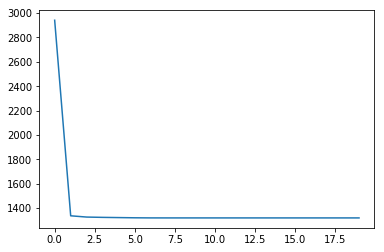

K = 3: objective function for 20 iterations


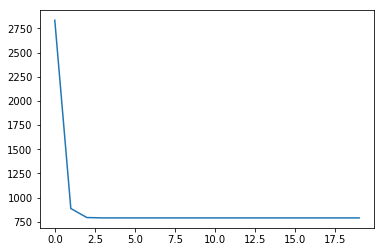

K = 4: objective function for 20 iterations


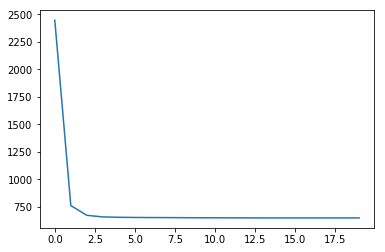

K = 5: objective function for 20 iterations


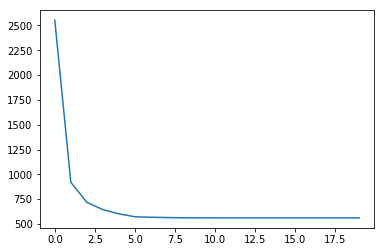

K = 3: cluster plot


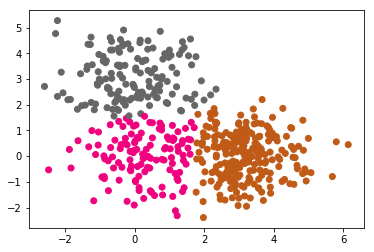

K = 5: cluster plot


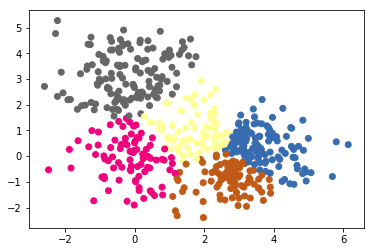

In [103]:
def task(k,p,whichtask):
    x, y = np.transpose(p)
    n = len(x)
    c_value = init_k(n,k)
    mu_list = init_mu(x,y,k)
    x_range = np.arange(20)
    loss_ls=[]
    for i in range(20):
        mu_list = [compute_mu([(x[p_idx], y[p_idx],) for p_idx in range(n) if c_value[p_idx]==mu_idx],n,x,y) for mu_idx in range(k)]
        c_value = [compute_c(xy,mu_list) for xy in p]
        loss_ls.append(get_loss(p,c_value,mu_list))
    if whichtask=='a':
        plt.plot(x_range,loss_ls)
        plt.show()
    elif whichtask=='b':
        mark_plot(p,c_value)
        plt.show()
for k in range(2,6):
    print('K = {}: objective function for 20 iterations'.format(k))
    task(k,p,'a')
for k in [3,5]:
    print('K = {}: cluster plot'.format(k))
    task(k,p,'b')    
        

# Task 2

## (a)

In [7]:
X_train_df = pd.read_csv('hw3-data/Prob2_Xtrain.csv',header=-1)

y_train_df = pd.read_csv('hw3-data/Prob2_ytrain.csv',header=-1)
y_train_df.columns = ['class']

df_train= pd.concat([X_train_df,y_train_df],axis =1)

In [10]:
def initEM(X_train,k):
    np.random.seed = 10
    cluster_dict={}
    for i in range(k):
        ep_mu = list(X_train[[0,1,2,3,4,5,6,7,8,9]].mean())
        ep_sigma = list(X_train[[0,1,2,3,4,5,6,7,8,9]].cov().values)
        mu = np.random.multivariate_normal(ep_mu, ep_sigma)
        cluster_dict[i]=[ep_mu,ep_sigma,mu]
    pi_list = [1/k for _ in range(k)]
    return cluster_dict,pi_list


In [11]:
def phi(kth,row,cluster_dict,pi_list):
    nominator = pi_list[kth]*multivariate_normal.pdf(row,cluster_dict[kth][2],cluster_dict[kth][1],allow_singular = True)
    denominator = sum([pi_list[i]*multivariate_normal.pdf(row,cluster_dict[i][2],cluster_dict[i][1],allow_singular = True) for i in range(len(pi_list))])
    return nominator/denominator

In [12]:
def get_phi_list(k,rows,cluster_dict,pi_list):
    return [[phi(kth,row,cluster_dict,pi_list) for kth in range(k)] for row in rows]

In [13]:
def update_nk_list(k,phi_list):
    return [sum(np.transpose(phi_list)[kth]) for kth in range(k)]

In [14]:
def update_pi(k,phi_list,n):
    return [sum(np.transpose(phi_list)[kth])/n for kth in range(k)]

In [15]:
def update_cluster_dict(rows,phi_list,cluster_dict,nk_list,k):
    for kth in range(k):

        cluster_dict[kth][2] = (np.dot(np.transpose(phi_list)[kth],np.array(rows))/nk_list[kth]).tolist()
        cluster_dict[kth][1] = sum([np.dot(np.transpose([rows[i]-cluster_dict[kth][2]]),[rows[i]-cluster_dict[kth][2]])*phi_list[i][kth] for i in range(len(rows))])/nk_list[kth] 

In [16]:
def loss_funct(rows,cluster_dict,k,pi_list):
    
    return sum([np.log(sum([pi_list[kth]*multivariate_normal.pdf(row,cluster_dict[kth][2],cluster_dict[kth][1],allow_singular = True) for kth in range(k)])) for row in rows])

In [17]:
def GMM(k,iterations,X_train,isplot=None,isshow=None):
    n = len(X_train)
    loss_list = []
    cluster_dict,pi_list = initEM(X_train,k)
    rows = X_train[[0,1,2,3,4,5,6,7,8,9]].values
    x_range = np.arange(5,iterations)
    for _ in range(iterations):
        phi_list = get_phi_list(k,rows,cluster_dict,pi_list)
        nk_list = update_nk_list(k,phi_list)
        pi_list = update_pi(k,phi_list,n)
        update_cluster_dict(rows,phi_list,cluster_dict,nk_list,k)
#         print(cluster_dict)
        loss = loss_funct(rows,cluster_dict,k,pi_list)
        loss_list.append(loss)
#         print(loss)
    if isplot:
        plt.plot(x_range,loss_list[5:])
        if isshow:
            plt.show()
    return cluster_dict, loss_list[-1], pi_list

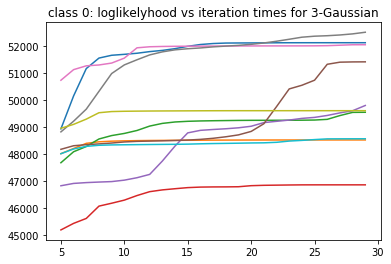

In [22]:
df_input = df_train[df_train['class']==0].reset_index().drop('index',axis=1)
c_list0 = []
loss_ls0 = []
pi_ls0 = []
for _ in range(10):
    c,l,pi = GMM(3,30,df_input,1)
    c_list0.append(c)
    loss_ls0.append(l)
    pi_ls0.append(pi)
plt.title('class 0: loglikelyhood vs iteration times for 3-Gaussian')
plt.show()

class1


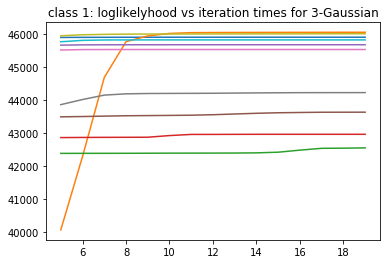

In [24]:
df_input = df_train[df_train['class']==1].reset_index().drop('index',axis=1)
c_list1 = []
loss_ls1 = []
pi_ls1 = []
for _ in range(10):
    c,l,pi = GMM(3,20,df_input,1)
    c_list1.append(c)
    loss_ls1.append(l)
    pi_ls1.append(pi)
print('class1')
plt.title('class 1: loglikelyhood vs iteration times for 3-Gaussian')
plt.show()


## (b)

In [25]:
X_test_df = pd.read_csv('hw3-data/Prob2_Xtest.csv',header=-1)
y_test_df = pd.read_csv('hw3-data/Prob2_ytest.csv',header=-1)
y_test_df.columns = ['class']
df_test= pd.concat([X_test_df,y_test_df],axis =1)

In [26]:
def get_prob(rows,cluster_dict,pi_list,k):
    
    return [sum([pi_list[kth]*multivariate_normal.pdf(row,cluster_dict[kth][2],cluster_dict[kth][1],allow_singular = True) for kth in range(k)]) for row in rows]
def accuracy(true_ls,pred_ls):
    con_mtx = [[0,0],[0,0]]
    for t,p in zip(true_ls,pred_ls):
        con_mtx[t][p] += 1
    acc = (con_mtx[1][1]+con_mtx[0][0])/len(pred_ls)
    return con_mtx,acc
         

In [27]:
def GMM_b(k,df_train,df_test):
    prob_compare_list = []
    for classnum in range(2):
        df_input = df_train[df_train['class']==classnum].reset_index().drop('index',axis=1)
        c_list0 = []
        loss_ls0 = []
        pi_ls0 = []
        for _ in range(10):
            c,l,pi = GMM(k,30,df_input)
            c_list0.append(c)
            loss_ls0.append(l)
            pi_ls0.append(pi)
        # print('class0')
        # plt.title('loglikelyhood vs iteration times')
        # plt.show()
        best_idx = np.argmax(loss_ls0)
        cluster_dict0 = c_list0[best_idx]
        pi_list0 = pi_ls0[best_idx]
        rows = df_test[[0,1,2,3,4,5,6,7,8,9]].values

        prob_compare_list.append(get_prob(rows,cluster_dict0,pi_list0,k))
    pred = [np.argmax(x) for x in np.transpose(prob_compare_list)]
    mtx,acc = accuracy(df_test['class'].values,pred)
    print(mtx[0],'\n',mtx[1])
    print('accuracy',acc)

In [28]:
print('this is the result for 1-GMM')
GMM_b(1,df_train,df_test)

this is the result for 1-GMM
[180, 98] 
 [6, 176]
accuracy 0.7739130434782608


In [29]:
print('this is the result for 2-GMM')
GMM_b(2,df_train,df_test)

this is the result for 2-GMM
[198, 80] 
 [10, 172]
accuracy 0.8043478260869565


In [30]:
print('this is the result for 3-GMM')
GMM_b(3,df_train,df_test)

this is the result for 3-GMM
[205, 73] 
 [12, 170]
accuracy 0.8152173913043478


In [31]:
print('this is the result for 4-GMM')
GMM_b(4,df_train,df_test)

this is the result for 4-GMM
[207, 71] 
 [11, 171]
accuracy 0.8217391304347826


# Task 3

In [138]:
df_train = pd.read_csv('hw3-data/Prob3_ratings.csv',header=-1,dtype={0:int,1:int,2:float})




In [5]:
df_test = pd.read_csv('hw3-data/Prob3_ratings_test.csv',header=-1,dtype={0:int,1:int,2:float})




In [74]:
M = scipy.sparse.csr_matrix((df_train[2].values, (df_train[0].values, df_train[1].values)))

In [73]:
M_values = df_train.values

In [8]:
u_num,v_num = M.shape
df_test = df_test[(df_test[0]<=u_num)&(df_test[1]<=v_num)].reset_index().drop('index',axis=1)

In [9]:
sigma_2 = 0.25
d = 10


In [169]:
def expand(mtx):
    mtx1 = []
    mtx2 = []
    for r in mtx:
        r1 = list(r)*len(r)
        r2 = np.array(r1).reshape(len(r),len(r)).T.reshape(1,-1)[0]
        mtx1.append(r1)
        mtx2.append(r2)
    VV = np.array(mtx1)*np.array(mtx2)
    return VV

def map_loss():
    take = df_train[[0,1]].values.astype(int)
    M_uv=(df_train[2].values-(U@V.T)[take.T[0].tolist(),take.T[1].tolist()])
    
    return -(sum(M_uv*M_uv)/2/sigma_2+sum((U@U.T).diagonal())/2+sum((V@V.T).diagonal())/2)

def test_MF():
    take = df_test[[0,1]].values.astype(int)
    return np.mean((df_test[2].values-(U@V.T)[take.T[0].tolist(),take.T[1].tolist()])**2)**(0.5)

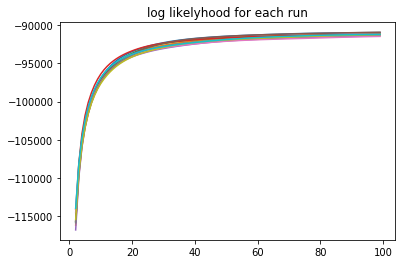

In [173]:
last_loss = []
rmse_ls = []
U_ls = []
V_ls = []
for run in range(10):
    
    loss_ls = []
    x_range = np.arange(100)
    V = np.random.multivariate_normal(np.zeros(d),np.identity(d),v_num)
    U = np.random.multivariate_normal(np.zeros(d),np.identity(d),u_num)
    
    i2j_loc = [df_train[df_train[0]==i][1].values for i in range(u_num)]
    i2j_val = [df_train[df_train[0]==i][2].values for i in range(u_num)]
    j2i_loc = [df_train[df_train[1]==i][0].values for i in range(v_num)]
    j2i_val = [df_train[df_train[1]==i][2].values for i in range(v_num)]

    for _ in range(100):
        VV = expand(V)
        for i in range(u_num):
            if len(i2j_loc[i])==0:
                continue
            first = inv(VV[i2j_loc[i]].sum(axis=0).reshape(d,d)+sigma_2*np.identity(d))
            second =(np.array([i2j_val[i]]).T*V[i2j_loc[i]]).sum(axis=0)            
            U[i] = first@second
            if i==1:
                pass
        UU = expand(U)
        for j in range(v_num):
            if len(j2i_loc[j])==0:
                continue
            first = inv(UU[j2i_loc[j]].sum(axis=0).reshape(d,d)+sigma_2*np.identity(d))
            second =(np.array([j2i_val[j]]).T*U[j2i_loc[j]]).sum(axis=0)
            V[j] = first@second
#             print(map_loss())
        loss_ls.append(map_loss())
#         print(map_loss())
    plt.plot(x_range[2:],loss_ls[2:])        
    last_loss.append(loss_ls[-1])
    rmse_ls.append(test_MF())
    U_ls.append(U)
    V_ls.append(V)
plt.title('log likelyhood for each run')
plt.show()

In [174]:
report_df = pd.DataFrame.from_dict({i:[last_loss[i],rmse_ls[i]] for i in range(10)},orient='index')
report_df.rename(columns = {0:'objective function',1:'rmse'},inplace=True)
report_df['run_id'] = np.arange(10)
report_df.sort_values('objective function',ascending=False)

,objective function,rmse,run_id
5,-90911.044581,1.138265,5
0,-90947.106289,1.136603,0
3,-91182.618095,1.123892,3
2,-91186.775611,1.143199,2
7,-91193.270942,1.153435,7
1,-91195.381937,1.109428,1
9,-91196.510037,1.107126,9
8,-91228.080716,1.119625,8
4,-91377.669844,1.097497,4
6,-91456.647531,1.126179,6


In [175]:
U = U_ls[np.argmax(last_loss)]
V = V_ls[np.argmax(last_loss)]

movie_df = pd.read_csv('hw3-data/Prob3_movies.txt',sep='\n',header=-1)

movie_df['idx'] = np.arange(1,1683)
movie_df.set_index('idx',inplace=True)
movie_df.rename(columns={0:'movie'},inplace=True)

display(movie_df[movie_df['movie'].isin(["Star Wars (1977)","My Fair Lady (1964)","GoodFellas (1990)"])])
SW = 50
GF = 182
MFL = 485
movie_list=[SW,GF,MFL]

,movie
idx,
50,Star Wars (1977)
182,GoodFellas (1990)
485,My Fair Lady (1964)


In [176]:
for movie in movie_list:
    dist_ls = [norm2(x) for x in V-V[movie]]
    near_df = movie_df.loc[np.argsort(dist_ls)[1:11]].reset_index()
    near_df['distance'] = np.array(dist_ls)[np.argsort(dist_ls)[1:11]]
    display(near_df)

,idx,movie,distance
0,172,"Empire Strikes Back, The (1980)",0.342762
1,181,Return of the Jedi (1983),0.593338
2,174,Raiders of the Lost Ark (1981),0.630624
3,429,"Day the Earth Stood Still, The (1951)",0.783113
4,12,"Usual Suspects, The (1995)",0.845176
5,186,"Blues Brothers, The (1980)",0.878820
6,210,Indiana Jones and the Last Crusade (1989),0.916055
7,195,"Terminator, The (1984)",1.007556
8,228,Star Trek: The Wrath of Khan (1982),1.024842
9,613,My Man Godfrey (1936),1.038923


,idx,movie,distance
0,693,Casino (1995),0.650422
1,187,"Godfather: Part II, The (1974)",0.829618
2,177,"Good, The Bad and The Ugly, The (1966)",0.893969
3,188,Full Metal Jacket (1987),0.927972
4,646,Once Upon a Time in the West (1969),0.958404
5,504,Bonnie and Clyde (1967),0.966579
6,135,2001: A Space Odyssey (1968),1.009904
7,205,Patton (1970),1.052390
8,469,Short Cuts (1993),1.060849
9,523,Cool Hand Luke (1967),1.073592


,idx,movie,distance
0,143,"Sound of Music, The (1965)",0.706647
1,419,Mary Poppins (1964),0.881198
2,417,"Parent Trap, The (1961)",0.978448
3,451,Grease (1978),0.983695
4,629,Victor/Victoria (1982),1.040539
5,699,Little Women (1994),1.061565
6,588,Beauty and the Beast (1991),1.078149
7,275,Sense and Sensibility (1995),1.091039
8,736,Shadowlands (1993),1.094906
9,845,That Thing You Do! (1996),1.122076
